<a href="https://colab.research.google.com/github/Jahnvi99/Leuphana-Intern/blob/master/Expected_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gpytorch

In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.integrate import simps
from numpy import trapz
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
def gaussian(x):
  return (torch.tensor(norm.pdf(x))).float()       

X = torch.linspace(-3, 3, 1200)
#mean = 0.0
#std = 1.0
y = gaussian(X)

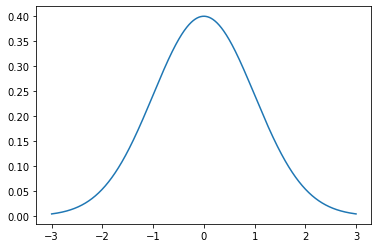

In [4]:
plt.plot(X,y)
plt.show()

In [5]:
trapz(y, dx=0.005)

0.99646914

In [6]:
# Using the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [8]:
X_sample = torch.tensor([ 1.3567,  2.2485, -2.6980])
y_sample = gaussian(X_sample)

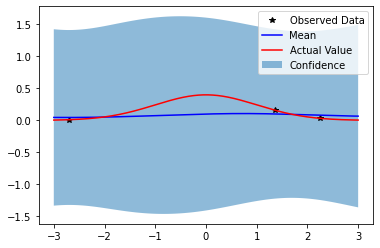

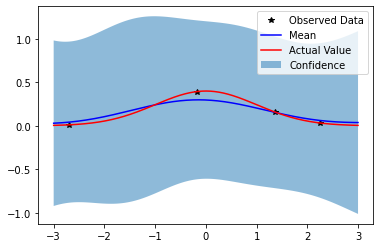

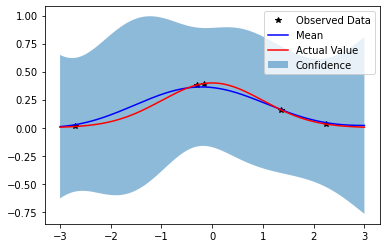

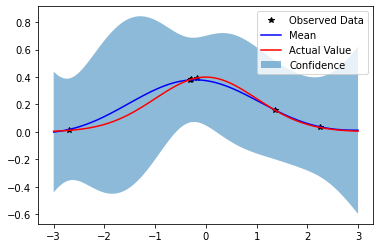

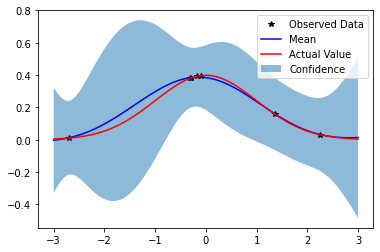

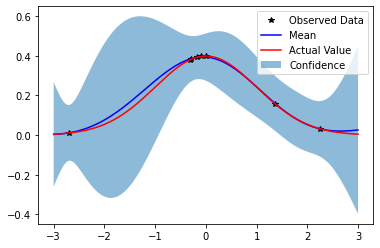

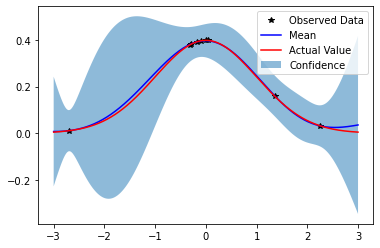

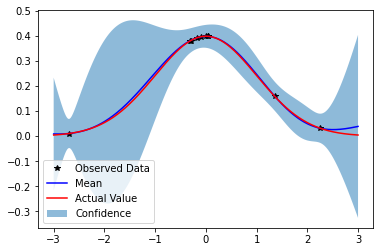

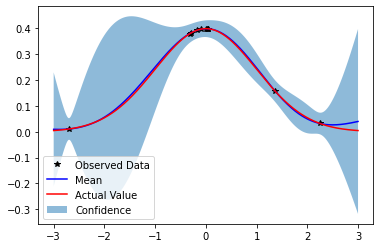

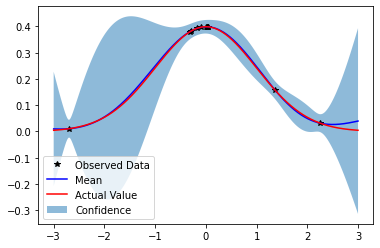

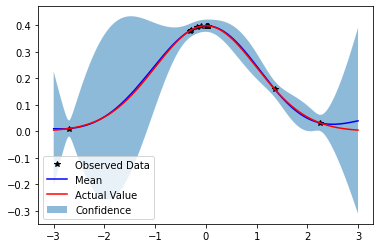

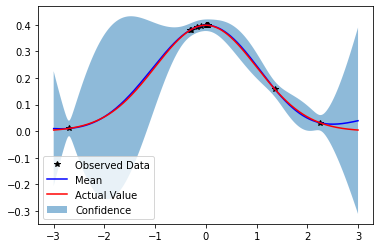

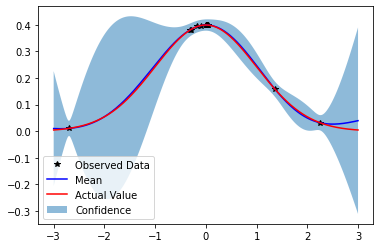

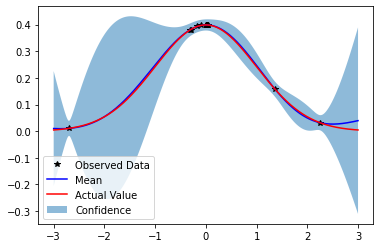

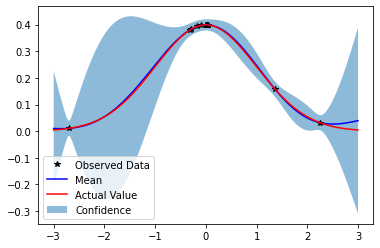

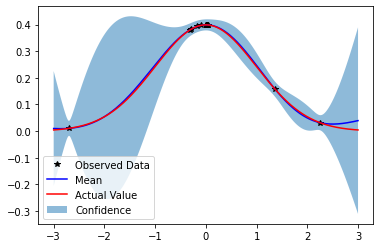

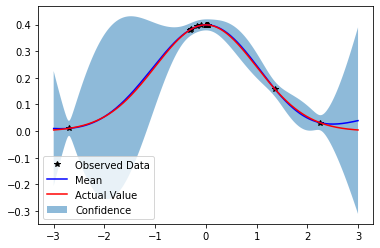

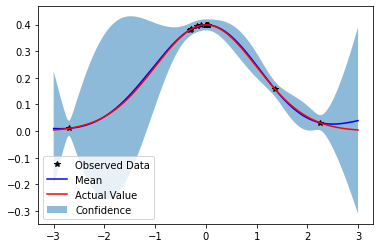

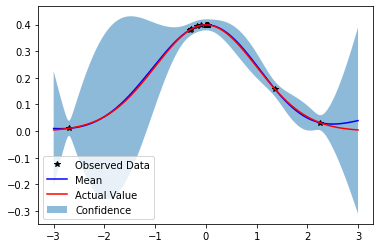

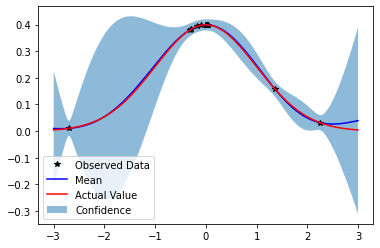

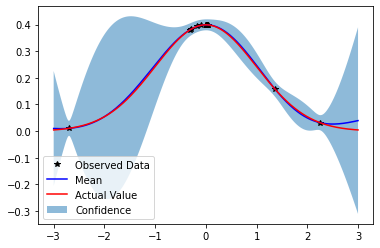

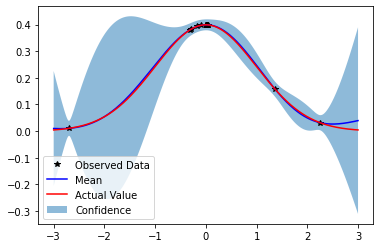

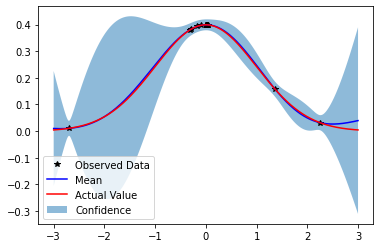

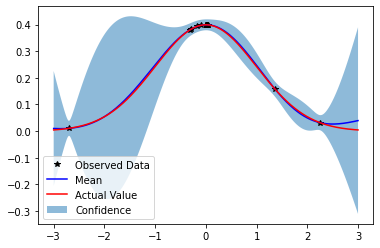

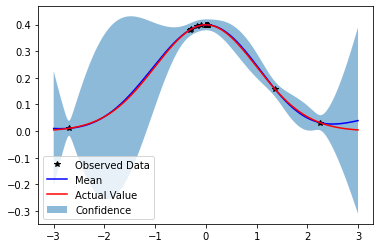

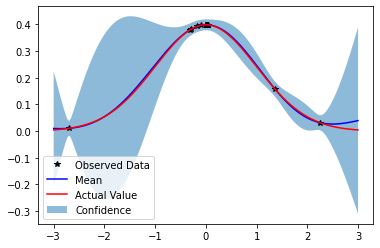

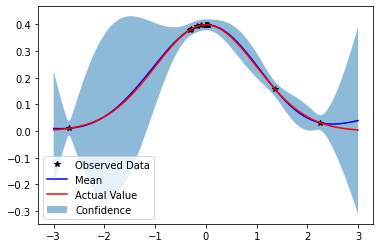

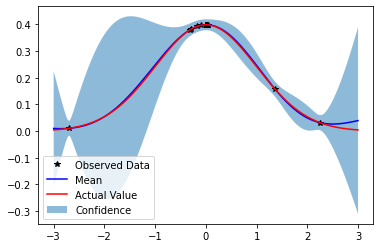

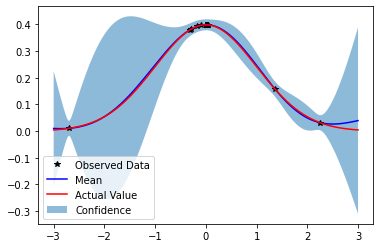

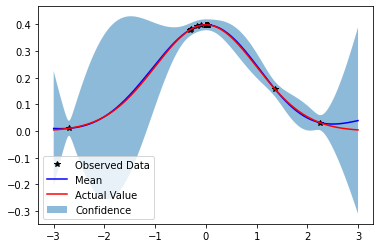

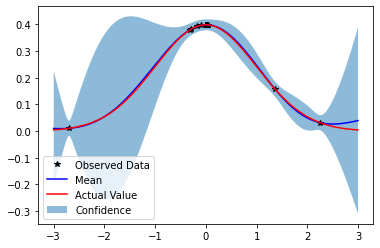

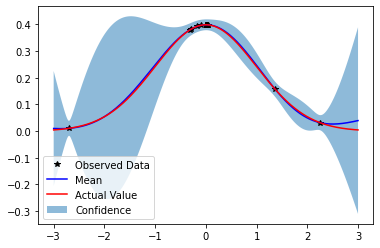

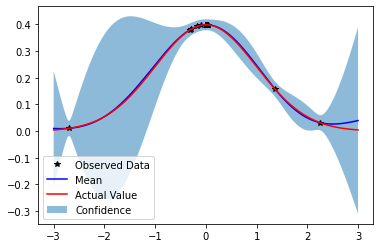

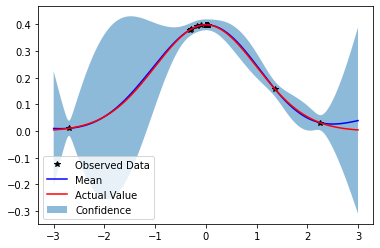

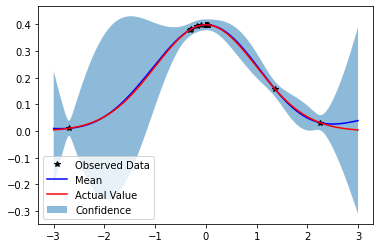

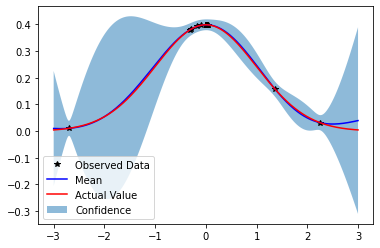

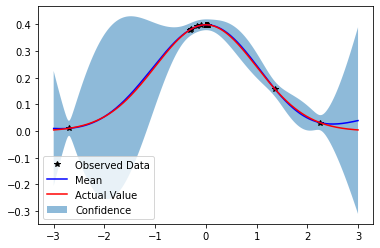

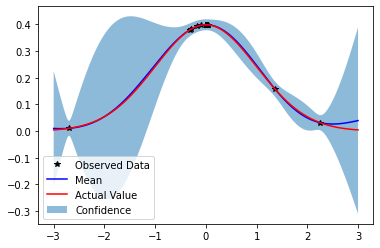

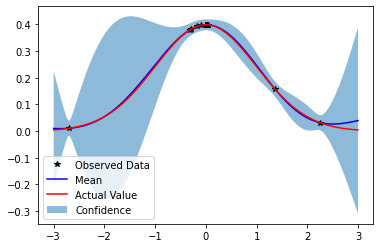

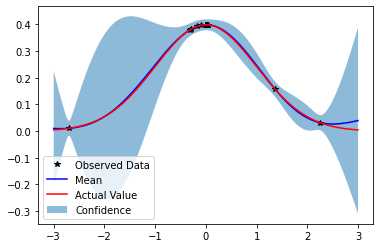

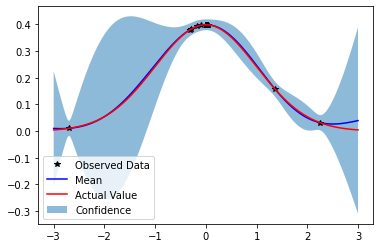

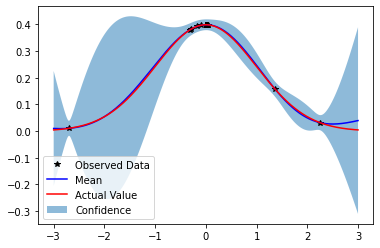

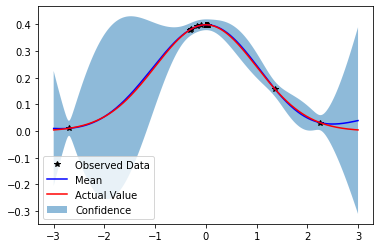

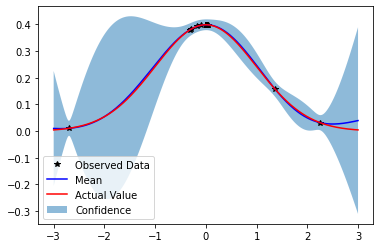

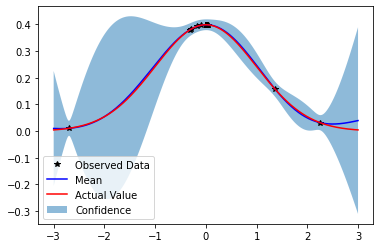

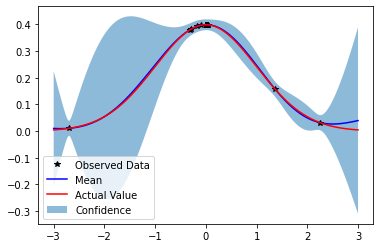

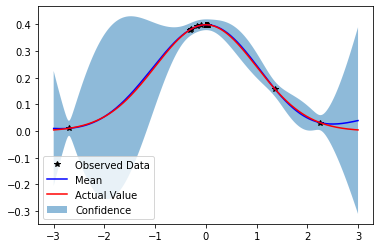

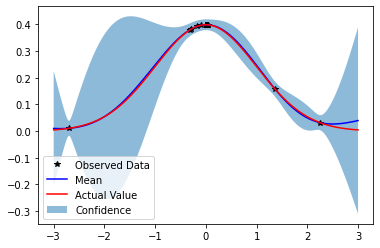

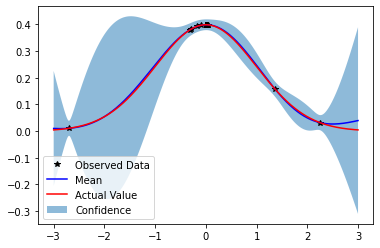

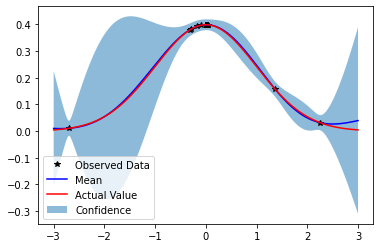

In [9]:
area1 = [] 
area2 = []

for i in range(50):
  model = ExactGPModel(X_sample, y_sample, likelihood)
  model.train()
  likelihood.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  for i in range(10):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_sample)
    # Calc loss and backprop gradients
    loss = -mll(output, y_sample)
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = X
    observed_pred = likelihood(model(test_x))
  with torch.no_grad():
    # Initialize plot
    #f, ax = plt.subplots()
    # Get standard deviation
    std = np.sqrt(observed_pred.variance.numpy())
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    mean = observed_pred.mean.numpy()
    #lower, upper = mean - std, mean + std
    # Plot training data as black stars
    plt.plot(X_sample.numpy(), y_sample.numpy(), 'k*')
    # Plot predictive means as blue line
    plt.plot(test_x.numpy(), mean, 'b')
    # Plot actual function as red line
    plt.plot(test_x.numpy(), y.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    plt.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ##ax.set_ylim([-3, 3])
    plt.legend(['Observed Data', 'Mean', 'Actual Value','Confidence'])
    plt.show()
  mu = observed_pred.mean
  sigma = torch.sqrt(observed_pred.variance)
  best_mu = torch.max(mu)
  check = (mu - best_mu - 1E-9)*torch.from_numpy(norm.cdf((mu - best_mu - 1E-9) / (sigma))) + sigma*torch.from_numpy(norm.cdf((mu - best_mu - 1E-9) / (sigma))) 
  temp = np.zeros(check.shape)
  check_copy = check.numpy()
  blah = np.maximum(temp, check_copy)
  idx = torch.argmax(torch.from_numpy(blah))
  p = torch.unsqueeze(X[idx], 0)  
  X_sample = torch.cat((X_sample, p))
  y_sample = gaussian(X_sample)  
  y_int = observed_pred.mean.numpy()  
  area1.append(trapz(y_int, dx=0.005))
  area2.append(simps(y_int, dx=0.005))    

In [10]:
plot_1 = []
plot_2 = []
for i in range(0,len(area1),5):
  plot_1.append(area1[i])
  plot_2.append(area2[i])

size = list(X_sample.shape)
x = []
for i in range(3, size[0], 5):
  x.append(i)

In [11]:
area1

[0.46985146,
 0.95932937,
 1.0777025,
 1.088465,
 1.078976,
 1.0512276,
 1.031836,
 1.0238044,
 1.0204321,
 1.0187026,
 1.0178071,
 1.0173855,
 1.0172043,
 1.0171255,
 1.0170902,
 1.0170711,
 1.0170679,
 1.0170579,
 1.0170364,
 1.017031,
 1.0170243,
 1.0170223,
 1.0170186,
 1.0170151,
 1.0170124,
 1.0170093,
 1.0170072,
 1.0170047,
 1.0170019,
 1.0169994,
 1.0169985,
 1.0169976,
 1.0169952,
 1.0169953,
 1.0169926,
 1.0169922,
 1.0169818,
 1.0169799,
 1.0169796,
 1.0169786,
 1.016967,
 1.0169661,
 1.0169684,
 1.01696,
 1.016959,
 1.0169592,
 1.0169597,
 1.0169495,
 1.0169476,
 1.0169477]

In [12]:
area2

[0.4698514980636537,
 0.9593294682307169,
 1.0777025570441037,
 1.0884651593398302,
 1.0789760080678388,
 1.0512274983990937,
 1.03183608581312,
 1.0238044683169574,
 1.0204321018233895,
 1.0187026881426573,
 1.0178071689791977,
 1.0173854659684003,
 1.0172042982652783,
 1.0171254060417414,
 1.0170901414938271,
 1.0170710865594446,
 1.0170677652209996,
 1.017057766225189,
 1.0170363103225828,
 1.0170309579744936,
 1.0170241734944283,
 1.0170221550762653,
 1.0170184680074454,
 1.0170148982293903,
 1.017012281678617,
 1.0170091888122261,
 1.0170072863064705,
 1.017004667930305,
 1.017001811861992,
 1.0169994309172035,
 1.0169984823465348,
 1.0169974130764603,
 1.016995150987059,
 1.0169952731952072,
 1.0169925345480442,
 1.0169920602068305,
 1.0169818039983511,
 1.0169799000583588,
 1.016979424674064,
 1.0169784733094276,
 1.01696702696383,
 1.0169660748355092,
 1.0169682220369578,
 1.016959991082549,
 1.01695892367512,
 1.016959161926061,
 1.016959523037076,
 1.0169495040550829,
 1.0169

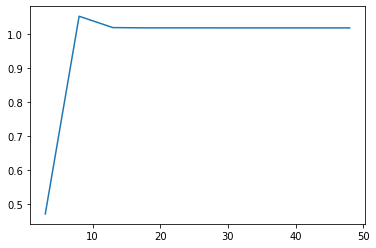

In [13]:
plt.plot(x,plot_1)
plt.show()

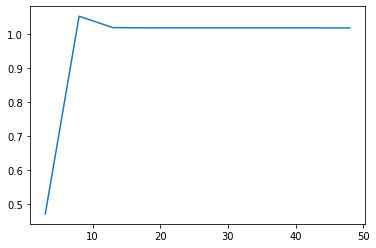

In [14]:
plt.plot(x,plot_2)
plt.show()

In [15]:
X_sample[0:3]

tensor([ 1.3567,  2.2485, -2.6980])